In [22]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
     

In [23]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
     

dog.jpg exists


In [24]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


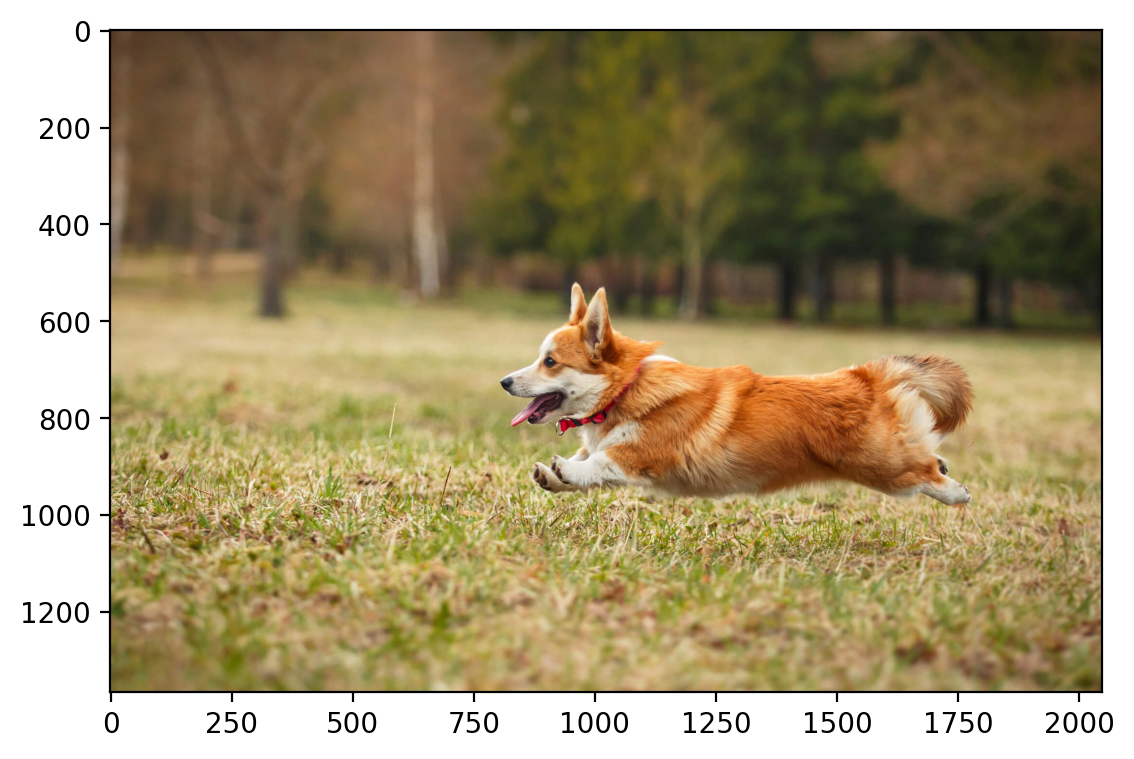

In [25]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


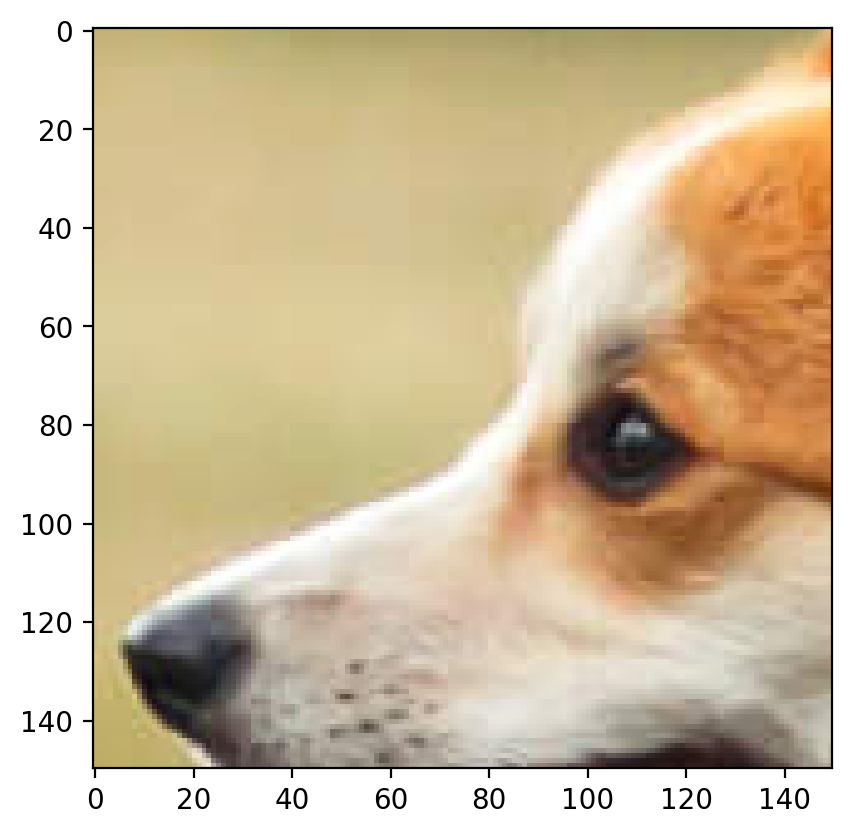

In [26]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
# scaler_img

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

img_scaled = img_scaled.to(device)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 150, 150)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())



In [27]:
crop = crop.to(device)
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [28]:
dog_X,dog_y = create_coordinate_map(crop)


In [29]:

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled.shape


torch.Size([22500, 2])

In [30]:

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [31]:

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()
     

In [32]:
def plot_reconstructed_and_original_image(original_img, net, X, title="",h=None,w=None):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    if(h==None ):
      num_channels, height, width = original_img.shape
    else:
      num_channels, height, width = 3,300,300
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [33]:

# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=2)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [34]:
X_rff = create_rff_features(dog_X_scaled, 15000, 0.008)
X_rff.shape

torch.Size([22500, 15000])

In [35]:

net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_y, 2500)

Epoch 0 loss: 0.487898
Epoch 100 loss: 0.081964
Epoch 200 loss: 0.018180
Epoch 300 loss: 0.010355
Epoch 400 loss: 0.007981
Epoch 500 loss: 0.006486
Epoch 600 loss: 0.005375
Epoch 700 loss: 0.004503
Epoch 800 loss: 0.003796
Epoch 900 loss: 0.003214
Epoch 1000 loss: 0.002727
Epoch 1100 loss: 0.002318
Epoch 1200 loss: 0.001973
Epoch 1300 loss: 0.001681
Epoch 1400 loss: 0.001433
Epoch 1500 loss: 0.001224
Epoch 1600 loss: 0.001046
Epoch 1700 loss: 0.000895
Epoch 1800 loss: 0.000767
Epoch 1900 loss: 0.000659
Epoch 2000 loss: 0.000568
Epoch 2100 loss: 0.000490
Epoch 2200 loss: 0.000424
Epoch 2300 loss: 0.000368
Epoch 2400 loss: 0.000321


0.000280615669908002

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


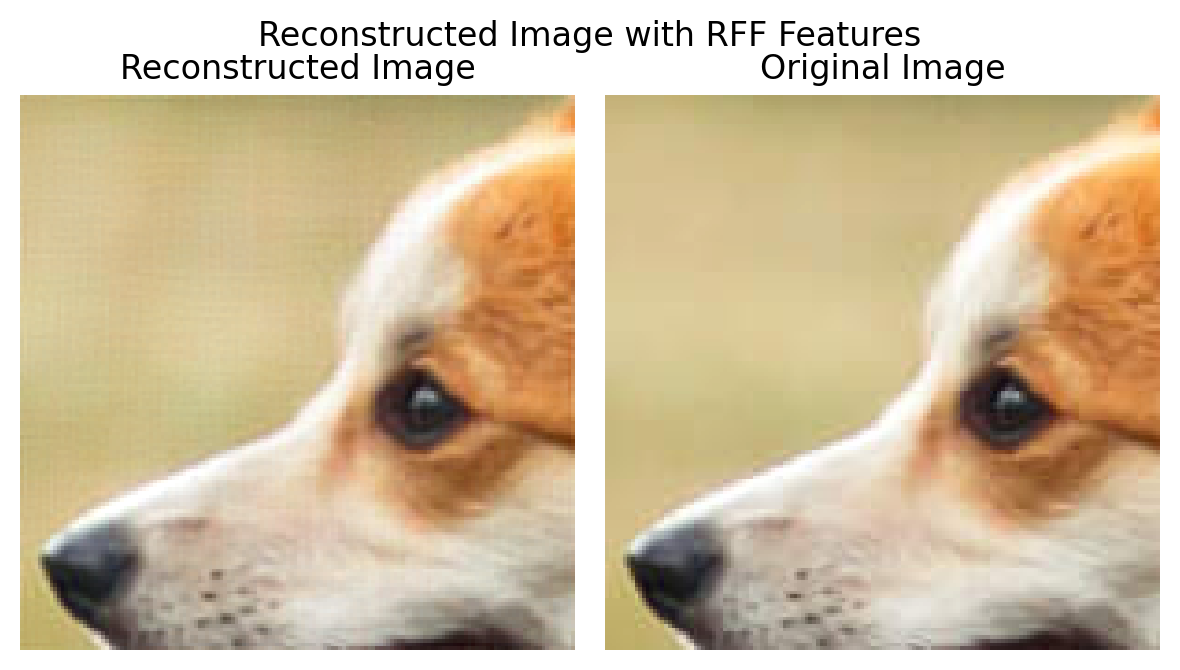

In [36]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")


In [37]:
dog2_X,dog2_y = create_coordinate_map(crop, scale=2)

# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog2_X.cpu())

# Scale the X coordinates
dog2_X_scaled = scaler_X.transform(dog2_X.cpu())

# Move the scaled X coordinates to the GPU
dog2_X_scaled = torch.tensor(dog2_X_scaled).to(device)

# Set to dtype float32
dog2_X_scaled = dog2_X_scaled.float()
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


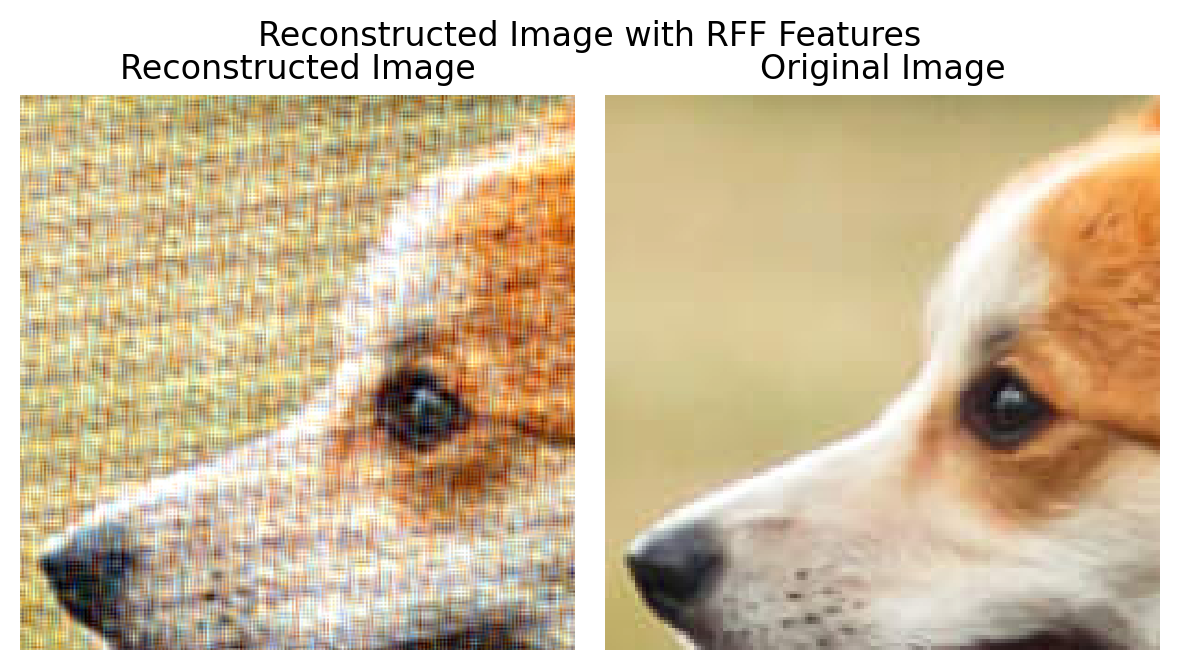

In [38]:
X2_rff = create_rff_features(dog2_X_scaled, 15000, 0.008)
plot_reconstructed_and_original_image(crop, net, X2_rff, title="Reconstructed Image with RFF Features",h='300',w='300')
